**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2020

# NuScale 720 SMR BoP Cortix Testing
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Students:** Jack and Nik <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor:** Prof. Valmor F. de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**11Dec2020**

In [1]:
try:
    import cortix, iapws
except ImportError:
    print('Installing missing packages...')
    print('')
    !pip install cortix iapws
    import cortix, iapws

from cortix import Cortix
from cortix import Network

from reactor import SMPWR
from steamer import Steamer
from condenser import Condenser
from turbine import Turbine

import unit

end_time = 1 * unit.hour 
time_step = 30.0 * unit.second
show_time = (True, 5*unit.minute)

plant = Cortix(use_mpi=False, splash=True) # System top level

plant_net = plant.network = Network() # Network

[15164] 2020-11-21 15:16:40,374 - cortix - INFO - Created Cortix object 
_____________________________________________________________________________
                             L A U N C H I N G                               
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%

In [2]:
'''Reactor'''

reactor = SMPWR()  # Create reactor module

reactor.name = 'SMPWR'
reactor.save = True
reactor.time_step = time_step
reactor.end_time = end_time
reactor.show_time = show_time

plant_net.module(reactor)  # Add reactor module to network

In [3]:
'''Steamer'''

steamer = Steamer()  # Create steamer module

steamer.name = 'Steamer'
steamer.save = True
steamer.time_step = time_step
steamer.end_time = end_time
steamer.show_time = show_time

plant_net.module(steamer)  # Add steamer module to network

In [4]:
'''Turbine'''

turbine = Turbine()  # Create turbine module

turbine.name = 'Turbine'
turbine.save = True
turbine.time_step = time_step
turbine.end_time = end_time
turbine.show_time = show_time

#plant_net.module(turbine)  # Add turbine module to network

In [5]:
'''Condenser'''

condenser = Condenser()  # Create condenser module

condenser.name = 'Condenser'
condenser.save = True
condenser.time_step = time_step
condenser.end_time = end_time
condenser.show_time = show_time

#plant_net.module(condenser)  # Add condenser module to network

In [6]:
#'''Feedwater Heating system'''

#condenser = FWHS()  # Create condenser module

#condenser.name = 'Condenser'
#condenser.save = True
#condenser.time_step = time_step
#condenser.end_time = end_time
#condenser.show_time = show_time

#plant_net.module(condenser)  # Add condenser module to network

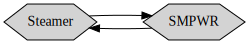

In [7]:
'''Balance of Plant Network Connectivity'''

plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'])
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'])
#plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'])
#plant_net.connect([turbine, 'outflow'], [condenser, 'condenser-inflow'])
#plant_net.connect([condenser, 'condenser-outflow'], [steamer, 'secondary-inflow'])

plant_net.draw()

In [8]:
'''Run'''

plant.run()  # Run network dynamics simulation

[15164] 2020-11-21 15:16:42,443 - cortix - INFO - Launching Module <reactor.SMPWR object at 0x0000022FBC324848>
[15164] 2020-11-21 15:16:42,607 - cortix - INFO - Launching Module <steamer.Steamer object at 0x0000022FBC358208>
[15164] 2020-11-21 15:16:48,515 - cortix - INFO - run()::Elapsed wall clock time [s]: 8.14


In [9]:
'''Close'''

plant.close()  # Properly shutdow plant

[15164] 2020-11-21 15:16:48,521 - cortix - INFO - Closed Cortix object.
_____________________________________________________________________________
                           T E R M I N A T I N G                             
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%8

In [10]:
reactor = plant_net.modules[0]

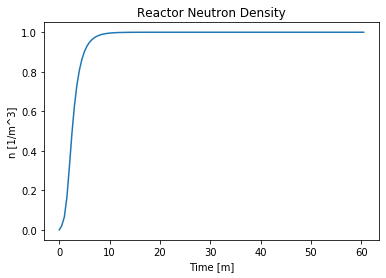

In [11]:
(quant, time_unit) = reactor.neutron_phase.get_quantity_history('neutron-dens')
quant.plot(x_scaling=1/unit.minute, y_scaling=1/max(quant.value), x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

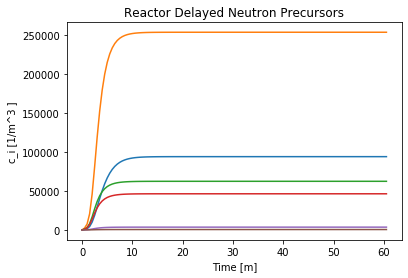

In [12]:
(quant, time_unit) = reactor.neutron_phase.get_quantity_history('delayed-neutrons-cc')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

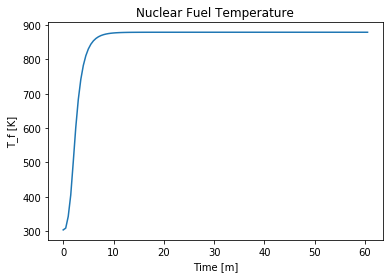

In [13]:
(quant, time_unit) = reactor.reactor_phase.get_quantity_history('fuel-temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

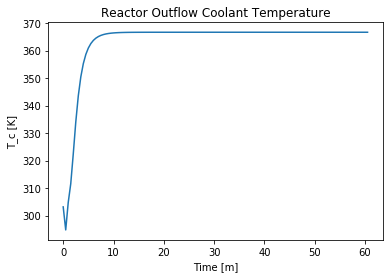

In [14]:
(quant, time_unit) = reactor.coolant_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

In [15]:
(quant, time_unit) = steamer.secondary_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

## [References](#toc)<a id="refs"></a>

1. Nuclear Reactor Engineering, [Engy-4350](https://github.com/dpploy/engy-4350) UMass Lowell, Dept. Chemical Engineering.